In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("doordash.csv")

In [3]:
df.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2/6/2015 22:24,2/6/2015 23:27,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2/10/2015 21:49,2/10/2015 22:56,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,1/22/2015 20:39,1/22/2015 21:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2/3/2015 21:21,2/3/2015 22:13,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2/15/2015 2:40,2/15/2015 3:20,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
#  Convert timestamps and create target variable (delivery_duration in minutes)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()/60

In [5]:
# STEP 4: Select Raw Numeric Features Only
# -----------------------------
numeric_columns = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'
]

df_v1 = df[numeric_columns + ['delivery_duration']].dropna()

In [6]:
# STEP 5: Define X and y
# -----------------------------
X = df_v1[numeric_columns]
y = df_v1['delivery_duration']

In [7]:
#STEP 6: Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# STEP 7: Define Models
# -----------------------------
models_v1 = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=8, random_state=42),    
    'XGBoost': XGBRegressor(n_estimators=30, max_depth=4, learning_rate=0.1, random_state=42)
}

In [8]:
# STEP 8: Evaluation Function
# -----------------------------
def evaluate_model(y_true, y_pred):
    return {
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'RMSE': round(root_mean_squared_error(y_true, y_pred)),
        'R²': round(r2_score(y_true, y_pred), 4)
    }

In [9]:
# STEP 9: Train and Evaluate Each Model
# -----------------------------
results_v1 = {}
for name, model in models_v1.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_v1[name] = evaluate_model(y_test, y_pred)

# -----------------------------
# STEP 10: View Results
# -----------------------------
import pprint
print("V1 Benchmark Results:")
pprint.pprint(results_v1)

V1 Benchmark Results:
{'LinearRegression': {'MAE': 11.77, 'RMSE': 17, 'R²': 0.2072},
 'Random Forest': {'MAE': 12.08, 'RMSE': 21, 'R²': -0.1566},
 'Ridge': {'MAE': 11.77, 'RMSE': 17, 'R²': 0.2072},
 'XGBoost': {'MAE': 12.05, 'RMSE': 18, 'R²': 0.1632}}


In [18]:
# Step 1: Re-train the best model (if not already stored separately)
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)

# Step 2: Extract feature names and coefficients
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_
})

# Step 3: Add absolute value of coefficient for ranking
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()

# Step 4: Sort by importance
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Step 5: Show top 10 most influential features
print("Top 10 Most Influential Features (Ridge Regression):")
print(coefficients_df.head(10))

Top 10 Most Influential Features (Ridge Regression):
                                        Feature  Coefficient  Abs_Coefficient
2                            num_distinct_items     0.503362         0.503362
7                         total_onshift_dashers    -0.366917         0.366917
9                      total_outstanding_orders     0.359585         0.359585
8                            total_busy_dashers    -0.134669         0.134669
5                estimated_order_place_duration     0.021175         0.021175
6  estimated_store_to_consumer_driving_duration     0.019674         0.019674
0                                   total_items    -0.006234         0.006234
1                                      subtotal     0.001445         0.001445
4                                max_item_price     0.000962         0.000962
3                                min_item_price     0.000076         0.000076


C:\Users\khach\AppData\Local\Temp\ipykernel_56620\2014068818.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


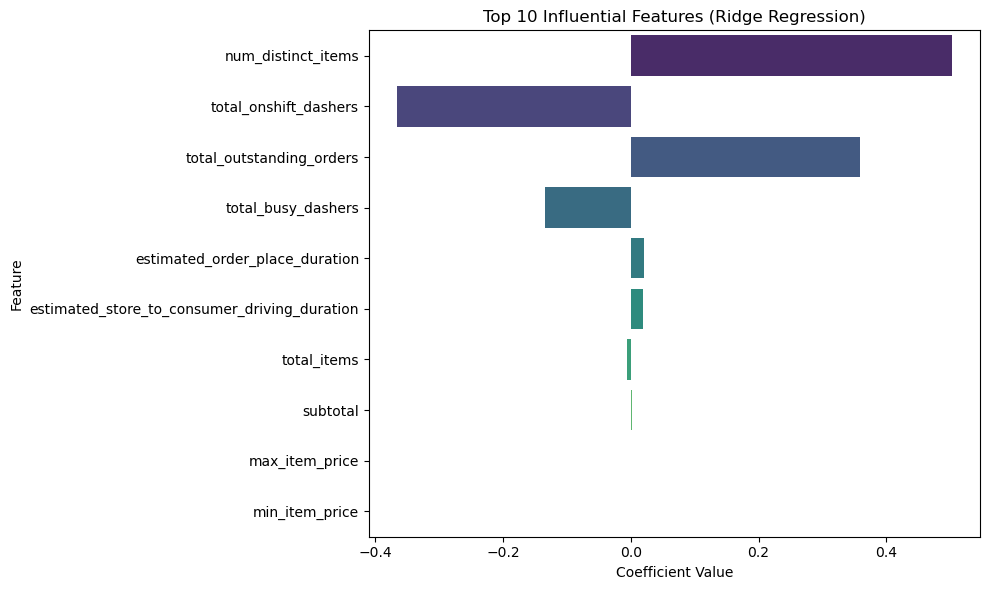

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients_df.head(10),
    x='Coefficient',
    y='Feature',
    palette='viridis'
)
plt.title("Top 10 Influential Features (Ridge Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

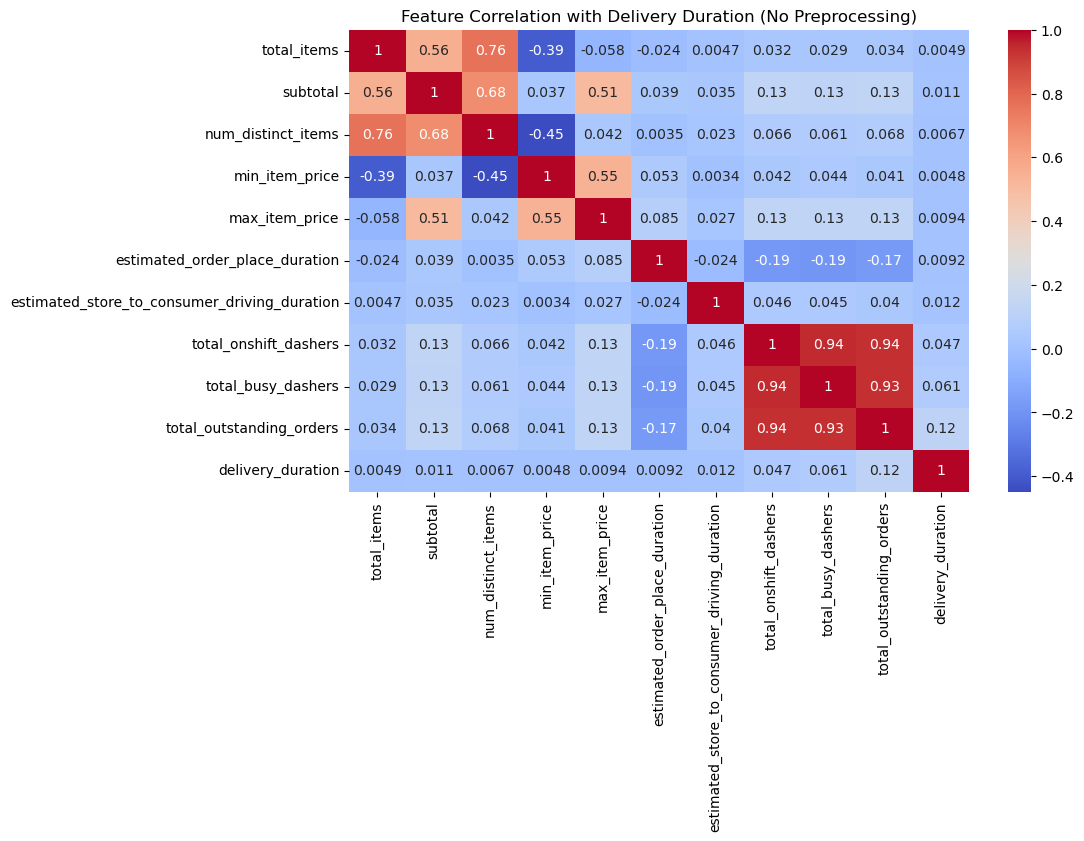

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_columns + ['delivery_duration']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Delivery Duration (No Preprocessing)")
plt.show()

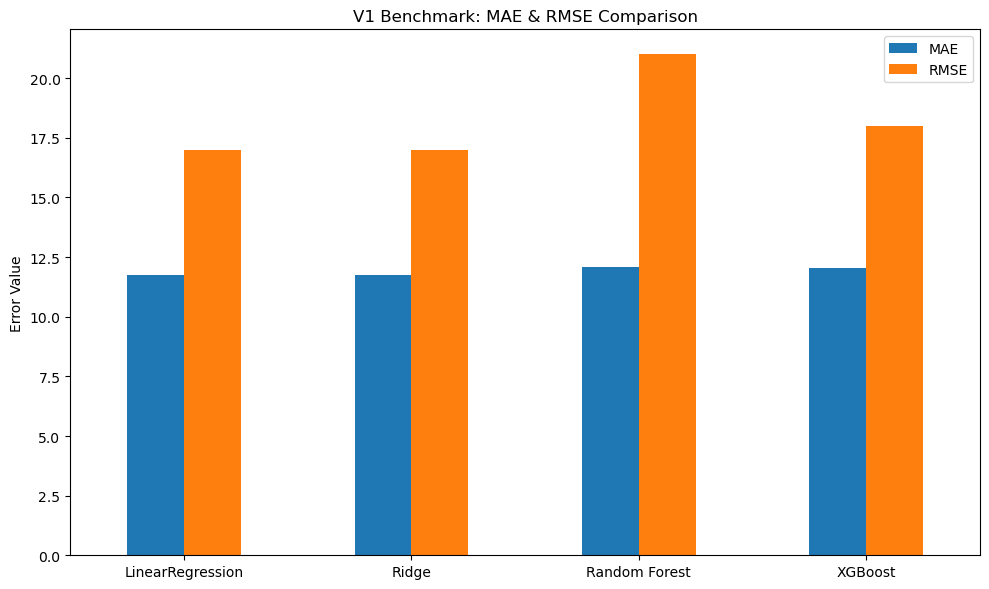

In [11]:
df_v1_results = pd.DataFrame(results_v1).T  # Transpose to get models as rows
df_v1_results
df_v1_results[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title("V1 Benchmark: MAE & RMSE Comparison")
plt.ylabel("Error Value")
plt.xticks(rotation=0)
#plt.grid(axis='y')
plt.tight_layout()
plt.show()

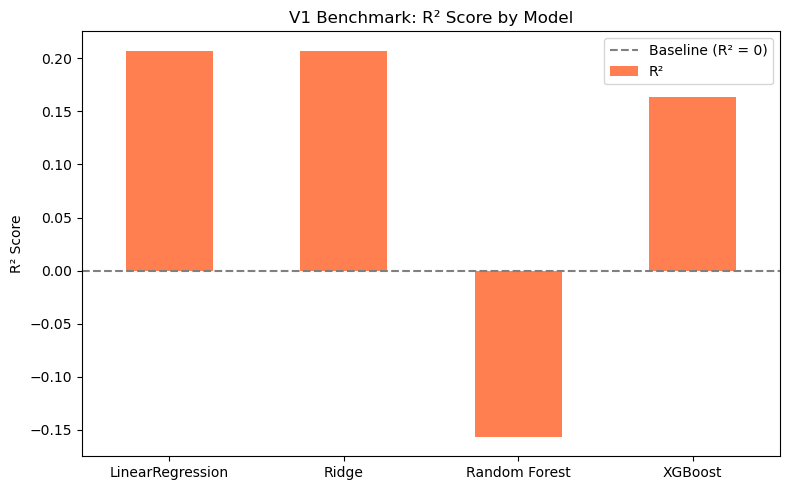

In [22]:
df_v1_results['R²'].plot(kind='bar', color='coral', figsize=(8, 5))
plt.title("V1 Benchmark: R² Score by Model")
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.axhline(0, color='gray', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
print(df['delivery_duration'].describe())

count    197421.000000
mean         48.473420
std         320.492084
min           2.000000
25%          35.000000
50%          44.000000
75%          56.000000
max      141947.000000
Name: delivery_duration, dtype: float64
